In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from scipy import sparse
import pickle

<h1>4. Machine Learning Models </h1>

<h2> 4.3 Random train test split( 70:30) </h2>

In [7]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [15]:
y_train = loadPickleData('y_train.pickle')
y_test = loadPickleData('y_test.pickle')
y_cv = loadPickleData('y_cv.pickle')
X_train = loadPickleData('train_f.pickle')
X_test = loadPickleData('test_f.pickle')
X_cv = loadPickleData('cv_f.pickle')

In [18]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.62746875 Class 1:  0.37253125
---------- Distribution of output variable in train data ----------
Class 0:  0.37255 Class 1:  0.37255


In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8861586593233449


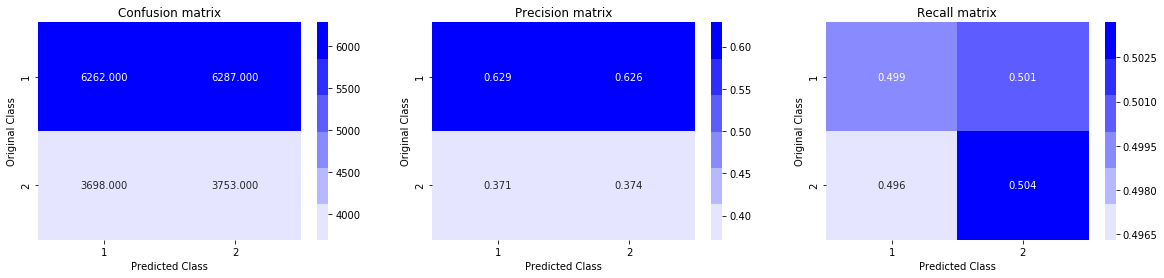

In [20]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [21]:
def plot(alpha,log_error_array):
    fig, ax = plt.subplots(figsize =(10,10))
    a = np.arange(len(alpha))
    ax.plot(a, log_error_array,c='g')
    for i, txt in enumerate(np.round(log_error_array,3)):
        ax.annotate((a[i],np.round(txt,3)), (a[i],log_error_array[i]))
    plt.grid()
    ax.set_xticks(a)
    ax.set_xticklabels(alpha)
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

# A1 

<h2>Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6603054154438797
For values of alpha =  0.0001 The log loss is: 0.6603054154438797
For values of alpha =  0.001 The log loss is: 0.6603054154438797
For values of alpha =  0.01 The log loss is: 0.6603054154438797
For values of alpha =  0.1 The log loss is: 0.5944988382070094
For values of alpha =  1 The log loss is: 0.6372755971249219
For values of alpha =  10 The log loss is: 0.6558483472136013
For values of alpha =  100 The log loss is: 0.6603099695702691
For values of alpha =  1000 The log loss is: 0.6603297297878117


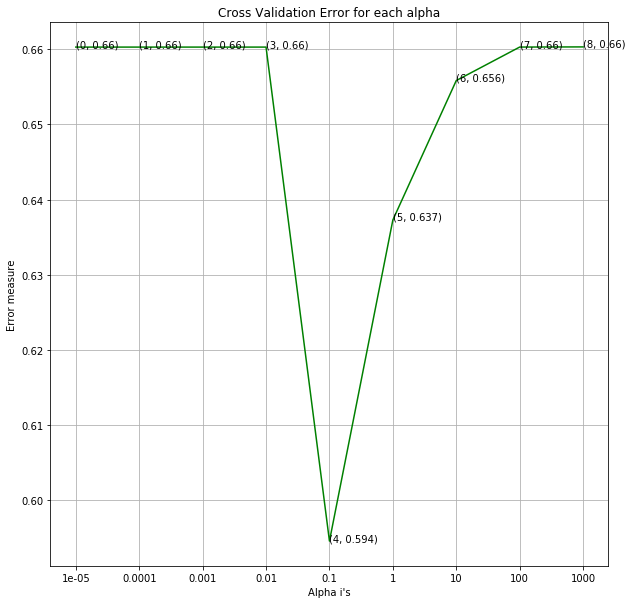

For values of best alpha =  0.1 The train log loss is: 0.6602891241368474
For values of best alpha =  0.1 The test log loss is: 0.6602988989210667
Total number of data points : 20000


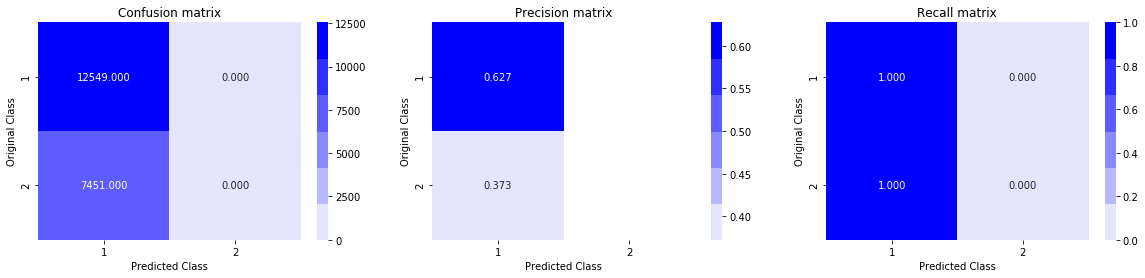

In [26]:
alpha = [10 ** x for x in range(-5, 4)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

plot(alpha,log_error_array)


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6603054154438797
For values of alpha =  0.0001 The log loss is: 0.6603054154438797
For values of alpha =  0.001 The log loss is: 0.6603054154438797
For values of alpha =  0.01 The log loss is: 0.6603054154438797
For values of alpha =  0.1 The log loss is: 0.5989173898417712
For values of alpha =  1 The log loss is: 0.6151992470222541
For values of alpha =  10 The log loss is: 0.6492073783203322


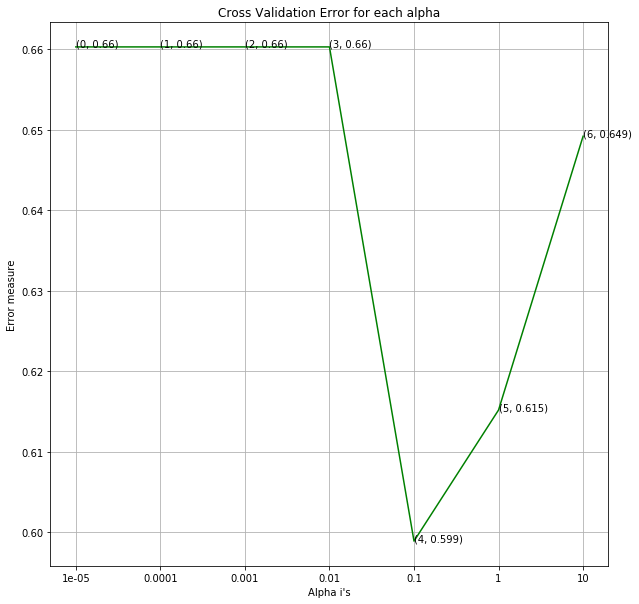

For values of best alpha =  0.1 The train log loss is: 0.5969050241848052
For values of best alpha =  0.1 The test log loss is: 0.5956379316526482
Total number of data points : 20000


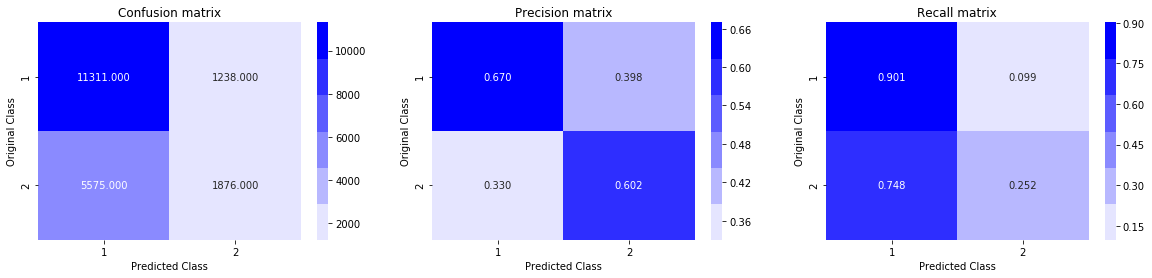

In [27]:
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


plot(alpha,log_error_array)

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## A2 

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [28]:
#X_train,X_test, y_train, y_test
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
x_cfl=XGBClassifier()

prams={
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10,100]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train ,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 83.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 95.5min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 105.2min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 500, 1000, 2000], 'max_depth': [3, 5, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [29]:
print (random_cfl.best_params_)

{'n_estimators': 2000, 'max_depth': 5}


In [30]:
best_n_estimators = random_cfl.best_params_['n_estimators']
best_max_depth = random_cfl.best_params_['max_depth']

For values of best no of estimators =  2000 The train log loss is: 0.21711923502198788
For values of best no of estimators =  2000 The test log loss is: 0.3338533534597732


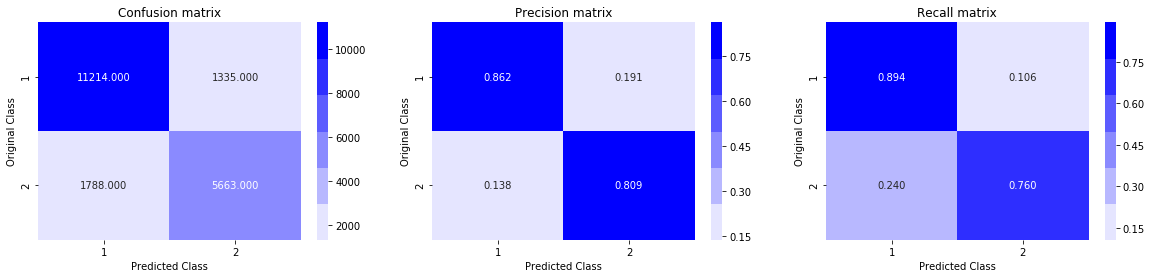

In [31]:
x_cfl=XGBClassifier(n_estimators=best_n_estimators,max_depth=best_max_depth)
x_cfl.fit(X_train,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best no of estimators = ', best_n_estimators, "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best no of estimators = ', best_n_estimators, "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,sig_clf.predict(X_test))

### Summary 

| Algorithm           | Hyperparamter                  | Log Loss |
|---------------------|--------------------------------|----------|
| Logistic Regression | alpha =0.1                     | 0.66     |
| Linear SVM          | alpha =0.1                     | 0.595    |
| XgBoost             | n_estimators =200 max_depth =5 | 0.33     |